In [1]:
import tensorflow as tf

from tensorflow import keras
import keras.backend.common
from keras.backend.common import image_dim_ordering
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten

#K.set_image_dim_ordering('tf')
#K.set_image_dim_ordering('tf')
#keras.backend.image_dim_ordering()
#K.common.image_dim_ordering()
from keras.utils import np_utils
from keras.callbacks import TensorBoard
from keras import regularizers

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import itertools

Using TensorFlow backend.


In [2]:
PATH = os.getcwd()

print(PATH)
#C:\Users\micka\Documents\Projets Persos\Object Detection
data_path = '../dev/Object Detection/data/'

data_dir_list = os.listdir(data_path)

C:\Users\micka\Documents\dev


In [3]:
print(data_dir_list)

['bike', 'cars', 'cats', 'dogs', 'flowers', 'horses', 'human']


In [4]:
img_rows = 128
img_cols = 128
num_channel = 1

## Define number of classes

num_classes = 7
img_data_list = []

for dataset in data_dir_list:
    
    img_list = os.listdir(data_path+'/'+dataset)
    print('Loading images of dataset of {}'.format(dataset))
    
    for img in img_list:
        #read image
        input_img = cv2.imread(data_path +'/'+ dataset+'/'+img)
        #convert image to grayscale
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        # reshape image
        resized_img = cv2.resize(input_img, (128,128))
        
        img_data_list.append(resized_img)

Loading images of dataset of bike
Loading images of dataset of cars
Loading images of dataset of cats
Loading images of dataset of dogs
Loading images of dataset of flowers
Loading images of dataset of horses
Loading images of dataset of human


In [5]:
img_data = np.array(img_data_list)

img_data = img_data.astype('float32')
img_data /= 255
print(img_data.shape)

(1803, 128, 128)


In [6]:
if num_channel==1:
    if image_dim_ordering()=='th':
        img_data= np.expand_dims(img_data, axis=1) 
        print (img_data.shape)
    else:
        img_data= np.expand_dims(img_data, axis=4) 
        print(img_data.shape)

else:
    if image_dim_ordering()=='th':
        img_data=np.rollaxis(img_data,3,1)
        print (img_data.shape)

(1803, 128, 128, 1)


In [7]:
num_classes = 7
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')
labels[0:365]=0
labels[365:567]=1
labels[567:987]=2
labels[987:1189]=3
labels[1189:1399]=4
labels[1399:1601]=5
labels[1601:1803]=6
names = ['bike', 'cars', 'cats', 'dogs', 'flowers', 'horses', 'human']

In [8]:
Y = np_utils.to_categorical(labels, num_classes)

In [9]:
x,y = shuffle(img_data, Y, random_state = 2)

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 2)

In [10]:
print("X_train_shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))

X_train_shape : (1442, 128, 128, 1)
X_test shape : (361, 128, 128, 1)


<function matplotlib.pyplot.show(*args, **kw)>

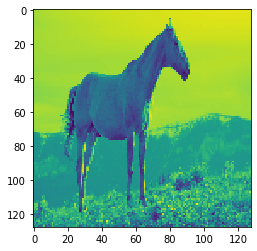

In [11]:
image = X_train[1203,:].reshape((128,128))
plt.imshow(image)
plt.show

In [14]:
input_dim = X_train[0].shape

In [16]:
input_dim

(128, 128, 1)

In [16]:
cnn_model = keras.Sequential()

cnn_model.add(Convolution2D(128,3,3, border_mode = 'same', activation = 'relu', input_shape = input_dim, kernel_regularizer = regularizers.l2(1e-4)))
cnn_model.add(Convolution2D(128,3,3, activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2)))
cnn_model.add(Dropout(0.5))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation = 'relu', activity_regularizer = regularizers.l2(1e-4)))
cnn_model.add(Dropout(0.5))


cnn_model.add(Dense(num_classes, activation = 'softmax'))

In [18]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 128)     1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 508032)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65028224  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [17]:
cnn_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam',#'adadelta',
                 metrics = ["accuracy"])

In [19]:
num_epoch = 25


history = cnn_model.fit(X_train, y_train, batch_size=256, 
                       epochs = num_epoch, verbose = True,
                       validation_data=(X_test, y_test))

#print(history.history)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


xc = range(num_epoch)

Train on 1442 samples, validate on 361 samples
Epoch 1/25
1442/1442 [==============================] - 1724s 1s/step - loss: 1.8370 - accuracy: 0.3474 - val_loss: 1.8510 - val_accuracy: 0.3850
Epoch 2/25
1442/1442 [==============================] - 2781s 2s/step - loss: 1.8050 - accuracy: 0.3911 - val_loss: 1.8035 - val_accuracy: 0.3989
Epoch 3/25
1442/1442 [==============================] - 759s 526ms/step - loss: 1.7506 - accuracy: 0.4404 - val_loss: 1.7740 - val_accuracy: 0.3878
Epoch 4/25
1442/1442 [==============================] - 822s 570ms/step - loss: 1.7291 - accuracy: 0.4452 - val_loss: 1.7528 - val_accuracy: 0.4432
Epoch 5/25
1442/1442 [==============================] - 690s 478ms/step - loss: 1.6799 - accuracy: 0.4716 - val_loss: 1.7319 - val_accuracy: 0.4543
Epoch 6/25
1442/1442 [==============================] - 692s 480ms/step - loss: 1.6379 - accuracy: 0.4979 - val_loss: 1.7060 - val_accuracy: 0.4654
Epoch 7/25
1442/1442 [==============================] - 735s 510ms/st

In [42]:
xc = range(50)

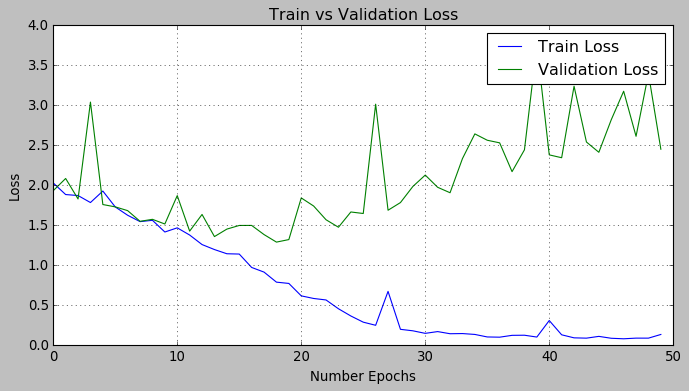

In [43]:
plt.figure(1, figsize=(10,5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('Number Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.grid(True)

plt.legend(['Train Loss', 'Validation Loss'])
plt.style.use(['classic'])

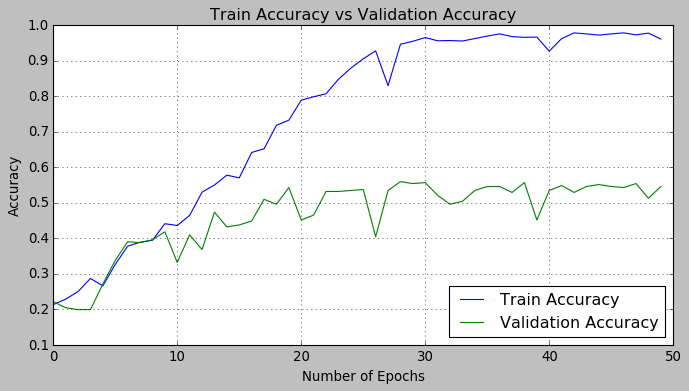

In [44]:
plt.figure(2,figsize=(10,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.grid(True)
plt.legend(['Train Accuracy','Validation Accuracy'],loc=4)
plt.style.use(['classic'])

In [46]:
score = cnn_model.evaluate(X_test, y_test, verbose=True)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

361/361 [==============================] - 1s 4ms/step
Test Loss: 4.2083533913144775
Test Accuracy: 0.5180055499076843


In [28]:
test_image = X_test[0:1]
print (test_image.shape)
print(cnn_model.predict(test_image))
print(cnn_model.predict_classes(test_image))
print(y_test[0:1])

(1, 128, 128, 1)
[[1.0000000e+00 1.1477056e-21 7.8716381e-16 3.3047822e-21 7.5874592e-23
  1.1699403e-21 5.8079904e-24]]
[0]
[[1. 0. 0. 0. 0. 0. 0.]]


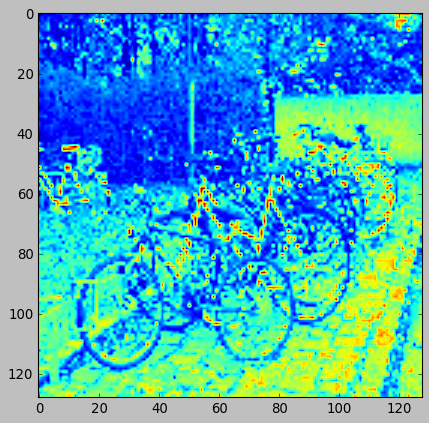

In [29]:
image = test_image.reshape((128,128))
plt.imshow(image)
plt.show()